In [1]:
import rasterio
from rasterio.plot import show as rastershow
from rasterio import mask

import sqlite3
import pandas as pd
import geopandas as gpd
import os

from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, box
import shapely

# Evaluate the finetuned model vs the pretrained model

Compare polygons by inference with 

- pretrained TCD model (k=0): `/work/ka1176/shared_data/2024-ufz-deeptree/pretrained_models/tcd-20cm-RGBI-v1/Unet-resnet18_epochs=209_lr=0.0001_width=224_bs=32_divby=255_custom_color_augs_k=0_jitted.pt`
- finetuned model (starting from k=0): `TODO`
- trained from scratch: `TODO`

We used the split
- 8 tiles for training
- 2 tiles for validation (early stopping based on IOU)
- 2 tiles for evaluation (`tile_19_19.tif` and `tile_1_1.tif`)

In [2]:
test_tile = '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/tiles/tile_19_19.tif'

# This is the pretrained model
pretrained_sqlite = '/work/ka1176/caroline/gitlab/TreeCrownDelineation/results/inference_halle/2024-10-25_09-36-19/test.sqlite'

# This is the model finetuned on Halle data
finetuned_sqlite = '/work/ka1176/caroline/gitlab/TreeCrownDelineation/results/inference_halle/2024-10-25_20-53-56/test.sqlite'

# Trained only on Halle data
trained_sqlite = '/work/ka1176/caroline/gitlab/TreeCrownDelineation/results/inference_halle/2024-10-25_09-31-27/test.sqlite'

In [3]:
def geoframe_from_sqlite(dbfile, col='test'):
    '''
    Create a GeoDataFrame with the geometries in the SQLITE database

    Arguments:
    dbfile (str): path to SQLITE database 
    '''

    if not os.path.exists(dbfile):
        print('No such file', dbfile)
        return None
    
    con = sqlite3.connect(dbfile)
    cur = con.cursor()
    try:
        df = pd.read_sql_query(f"SELECT * from {col}", con)
    except:
        print('Query failed for file', dbfile)
        return None
        
    con.close()
    geo = gpd.GeoSeries.from_wkb(df['GEOMETRY']).to_frame(f'geometry')

    return geo

In [4]:
ground_truth = gpd.read_file('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_19_19.shp')
ground_truth

,class,geometry
0,0,"POLYGON ((705916.207 5708002.269, 705919.608 5..."
1,0,"POLYGON ((705974.176 5708038.27, 705978.003 57..."
2,0,"POLYGON ((705924.002 5708073.987, 705928.254 5..."
3,1,"POLYGON ((705901.324 5708068.034, 705902.175 5..."
4,1,"POLYGON ((705922.159 5708038.978, 705923.86 57..."
5,0,"POLYGON ((705995.436 5708063.782, 705996.854 5..."
6,2,"POLYGON ((705987.443 5708025.496, 705988.127 5..."
7,0,"POLYGON ((705993.426 5708014.899, 705994.024 5..."


In [5]:
pretrained_polygons = geoframe_from_sqlite(pretrained_sqlite, col='test')
finetuned_polygons = geoframe_from_sqlite(finetuned_sqlite)
trained_polygons = geoframe_from_sqlite(trained_sqlite)

rastertif = rasterio.open(test_tile)

In [6]:
rastertif.crs

CRS.from_epsg(25832)

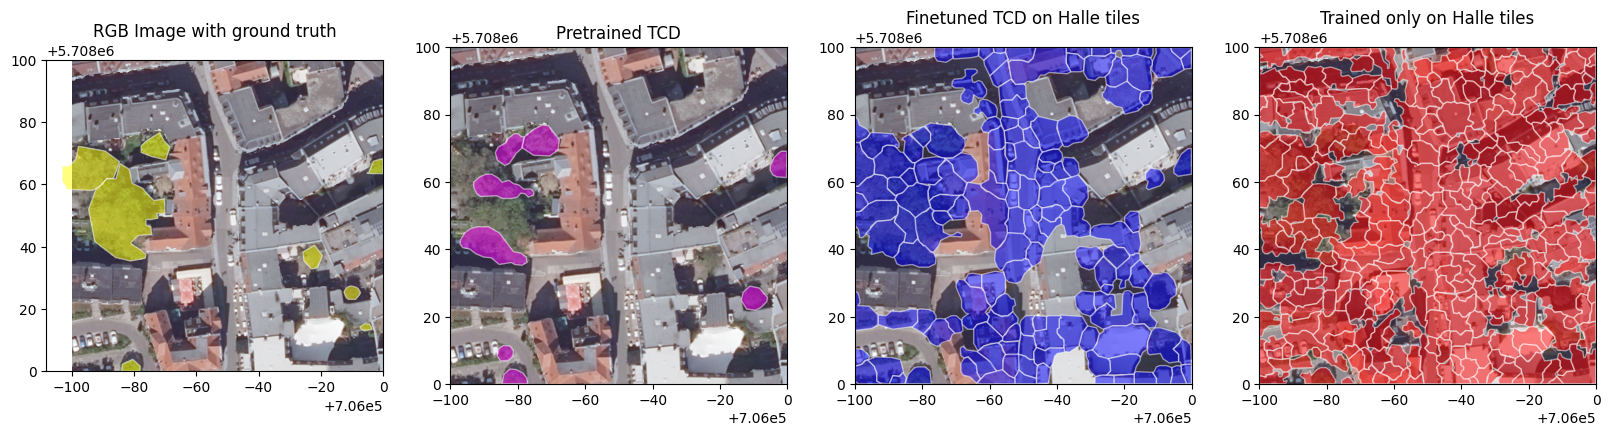

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7))

for axx in ax:
    rastershow(rastertif, ax=axx)

ground_truth.plot(ax=ax[0], color='yellow', edgecolor='white', alpha=0.5)

pretrained_polygons.plot(ax=ax[1], color='magenta', edgecolor='white', alpha=0.5)

finetuned_polygons.plot(ax=ax[2], color='blue', edgecolor='white',  alpha=0.5)

trained_polygons.plot(ax=ax[3], color='red', edgecolor='white', alpha=0.5)

ax[0].set_title('RGB Image with ground truth')
ax[1].set_title('Pretrained TCD')

ax[2].set_title('Finetuned TCD on Halle tiles')

ax[3].set_title('Trained only on Halle tiles')

plt.show()

## Evaluation

In [8]:
poly_dict = {'ground_truth': ground_truth,
             'pretrained_tcd': pretrained_polygons,
             'finetuned_halle': finetuned_polygons,
             'trained_halle': trained_polygons}

In [9]:
for key, poly in poly_dict.items():
    print(f'Number of polygons in {key:15s}: {len(poly)}')

Number of polygons in ground_truth   : 8
Number of polygons in pretrained_tcd : 8
Number of polygons in finetuned_halle: 139
Number of polygons in trained_halle  : 297


In [10]:
poly_union = {}
for key, poly in poly_dict.items():
    poly_union[key] = poly.union_all()

In [11]:
# intersection with ground truth
poly_inters = {}
poly_unions = {}
for key, poly in poly_union.items():
    poly_inters[key] = shapely.intersection(poly_union['ground_truth'], poly)
    poly_unions[key] = shapely.union(poly_union['ground_truth'], poly)

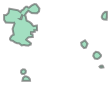

In [12]:
poly_unions['pretrained_tcd']

In [13]:
for key in poly_dict.keys():
    iou = poly_inters[key].area / poly_unions[key].area
    print(f'Intersection over union (IoU) for experiment {key:15s}:  {iou:.4f}')

Intersection over union (IoU) for experiment ground_truth   :  1.0000
Intersection over union (IoU) for experiment pretrained_tcd :  0.2948
Intersection over union (IoU) for experiment finetuned_halle:  0.1343
Intersection over union (IoU) for experiment trained_halle  :  0.0720
